### Importing Libraries

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import unicodedata
from contractions import contractions_dict
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
import transformers
from transformers import pipeline 
from transformers import DistilBertTokenizerFast
import torch
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Importing dataset

In [5]:
rdata = pd.read_csv('bert_data1.csv')

In [6]:
rdata.head ()

,processed,price
0,private patio balcony bbq area business cente...,1350
1,bedroom code link post totally remodeled upd...,1100
2,green community dishwasher central air condit...,980
3,onsite golf course guest suite available four...,1055
4,shelby township newest luxury apartment code...,1650


In [22]:
rdata.describe ()

,price
count,9807.000000
mean,1388.057408
std,938.570071
min,510.000000
25%,860.000000
50%,1100.000000
75%,1500.000000
max,14001.000000


In [11]:
rdata.dtypes

processed    object
price         int64
dtype: object

<AxesSubplot:>

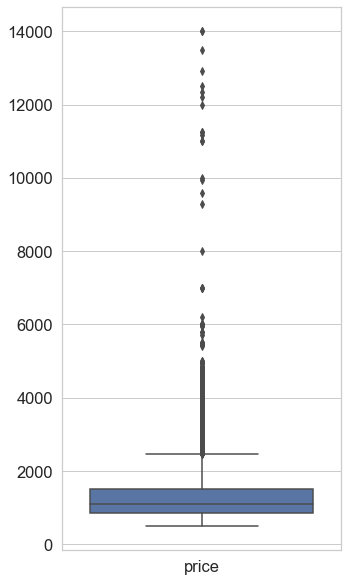

In [25]:
sns.set(rc = {'figure.figsize':(5, 10)}, font_scale = 1.5, style = 'whitegrid')
sns.boxplot (data = rdata)

In [27]:
def price_label (x):
    
    if x > 0 and x <= 500:
        return 0 
    elif x > 500 and x <= 800:
        return 1
    elif x > 800 and x <= 1000:
        return 2
    elif x > 1000 and x <= 1200:
        return 3
    elif x > 1200 and x <= 1500:
        return 4
    elif x > 1500 and x <= 1800:
        return 5
    elif x > 1800 and x <= 2000:
        return 6
    elif x > 2000 and x <= 2500:
        return 7
    elif x > 2500 and x <= 4000:
        return 8
    elif x > 4000 and x <= 6000:
        return 9
    elif x > 6000 and x <= 8000:
        return 10
    elif x > 8000 and x <= 12000:
        return 11
    else:
#       x > 12000
        return 12

rdata ['label'] = rdata ['price'].apply (price_label)

rdata.head ()

,processed,price,label
0,private patio balcony bbq area business cente...,1350,4
1,bedroom code link post totally remodeled upd...,1100,3
2,green community dishwasher central air condit...,980,2
3,onsite golf course guest suite available four...,1055,3
4,shelby township newest luxury apartment code...,1650,5


### Splitting into training and test sets

In [28]:
x_train, x_test, y_train, y_test = train_test_split (rdata ['processed'], rdata ['label'], test_size = 0.2, random_state = 1996)

### Let's check how well a base classifier model would do

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [116]:
vectorizer = TfidfVectorizer (ngram_range = (1, 2), min_df = 5)

x_train_trans = vectorizer.fit_transform (x_train)
x_test_trans = vectorizer.transform (x_test)

In [117]:
from sklearn.naive_bayes import MultinomialNB

NBmodel = MultinomialNB()

NBmodel.fit (x_train_trans, y_train)
y_pred_NB = NBmodel.predict (x_test_trans)

acc_NB = accuracy_score (y_test, y_pred_NB)
print ('NB Accuracy:', acc_NB)

NB Accuracy: 0.5524974515800204


In [132]:
## ANN
from sklearn.neural_network import MLPClassifier

MLPmodel = MLPClassifier (solver = 'lbfgs', hidden_layer_sizes = (10, 20, 10))

MLPmodel.fit (x_train_trans, y_train)
y_pred_MLP = MLPmodel.predict (x_test_trans)

acc_MLP = accuracy_score (y_test, y_pred_MLP)
print ('MLP Classifier accuracy:', acc_MLP)

MLP Classifier accuracy: 0.5056065239551478


### Let's see how well the BERT model can do in comparison

### Training a BERT Model

In [29]:
# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained ('distilbert-base-uncased')

# Padding and truncation of data
inputs = tokenizer (x_train.tolist(), padding = 'max_length', truncation = True)

labels = y_train.tolist ()

In [30]:
class tensorize (torch.utils.data.Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__ (self, idx):
        item = {key: torch.tensor (val [idx]) for key, val in self.encodings.items ()}
        item ['labels'] = torch.tensor (self.labels [idx])
        return item
    
    def __len__ (self):
        return len (self.labels)
    
train_dataset = tensorize (inputs, labels)

In [31]:
print (train_dataset.__getitem__(2))

{'input_ids': tensor([  101,  7997,  5527,  8102, 11980,  3229,  3642,  4957,  2695,  2148,
         8904,  4545,  8987,  2326,  9788,  3643,  4010,  2451,  4382,  2881,
         3749,  6020,  2542,  3325,  2148,  8904,  5292,  2392,  2067,  3332,
         7524,  4346,  2422,  2250,  2100,  7224,  5957,  2094, 10119,  9669,
         2392,  2311,  9324,  2312, 22944,  2330,  2686,  3584,  2457,  4632,
        12228, 16125,  9394,  2284, 13240,  4665,  3545,  5297,  2346,  3481,
         2395,  3640,  3622,  3229,  3518,  2082,  6023,  2415,  2350, 11194,
         4592, 10439, 15204,  3401,  9920,  5527,  3229,  8114,  1044, 24887,
         3177,  4274,  3229, 12695,  2181,  9346,  2265,  2592,  3942, 20874,
        11343,  3395,  2689,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [35]:
bertmodel = DistilBertForSequenceClassification.from_pretrained ('distilbert-base-uncased', num_labels = 13)

loading configuration file config.json from cache at C:\Users\svveg/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_position_embeddings": 512,
  "model_type

In [36]:
device = torch.device ('cuda:0' if torch.cuda.is_available () else 'cpu')
bertmodel.to (device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [72]:
training_args = TrainingArguments (output_dir = './results',
                                   num_train_epochs = 2,
                                   per_device_train_batch_size = 16,
                                   per_device_eval_batch_size = 64,
                                   warmup_steps = 500,
                                   weight_decay = 0.00001,
                                   logging_dir = './logs',
                                   logging_steps = 10,
                                  )
trainer = Trainer (model = bertmodel,
                  args = training_args,
                  train_dataset = train_dataset,
                  )

trainer.train ()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
C:\Users\svveg\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7845
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 982
  Number of trainable parameters = 66963469


Step,Training Loss
10,0.932200
20,0.905500
30,1.087000
40,1.053700
50,1.086100
60,1.116600
70,0.972200
80,1.156900
90,1.088500
100,1.086800


Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=982, training_loss=0.8987802611834649, metrics={'train_runtime': 45362.6157, 'train_samples_per_second': 0.346, 'train_steps_per_second': 0.022, 'total_flos': 2078821206005760.0, 'train_loss': 0.8987802611834649, 'epoch': 2.0})

In [80]:
preds1 = []

for i in x_train:
    test_encoding1 = tokenizer (i, truncation = True, padding = True)
    input_ids = torch.tensor (test_encoding1 ['input_ids']).to (device)
    attention_mask = torch.tensor (test_encoding1 ['attention_mask']).to (device)
    op = bert_pred (test_encoding1)
    preds1.append (op)

In [92]:
print (accuracy_score (y_train, preds1))
print (confusion_matrix (y_train, preds1))

0.7533460803059273
[[1495   64   11   12    1    0    0   17    0    0    0    0]
 [ 111 1323  208   54    4    0    2    5    0    0    0    0]
 [  37  140  999  215    9    2    1    3    0    0    0    0]
 [  23   34  146  855   75   32   11   37    0    0    0    0]
 [   1   17   11   84  313   10   18   47    0    0    0    0]
 [   0    1    8   36   39   64   25   29    0    0    0    0]
 [   0    2    1   17   18   17   69  147    2    0    0    0]
 [   1    2    3   10    7    4   10  720   27    0    0    0]
 [   0    0    0    1    3    1    4   60   72    0    0    0]
 [   0    0    0    0    0    0    0    4    1    0    0    0]
 [   1    2    1    1    0    0    0    3    0    0    0    0]
 [   0    1    0    1    1    0    0    2    0    0    0    0]]


In [73]:
preds2 = []

for i in x_test:
    test_encoding1 = tokenizer (i, truncation = True, padding = True)
    input_ids = torch.tensor (test_encoding1 ['input_ids']).to (device)
    attention_mask = torch.tensor (test_encoding1 ['attention_mask']).to (device)
    op = bert_pred (test_encoding1)
    preds2.append (op)

In [99]:
print (accuracy_score (y_test, preds2))
cf = confusion_matrix (y_test, preds2)
print (cf)

0.6253822629969419
[[342  39  14  13   0   0   0  10   0   0   0]
 [ 58 249  68  28   7   1   0   5   0   0   0]
 [ 16  56 193  59   4   3   0   7   0   0   0]
 [ 14  10  60 185  14   7   5  13   0   0   0]
 [  3   5   9  34  61   5   5  16   0   0   0]
 [  1   3   2  13   9   9   5  14   0   0   0]
 [  1   0   4  10   4   7  15  21   0   0   0]
 [  1   1   1   6   5   4   8 158   6   0   0]
 [  0   0   0   0   0   0   0  17  15   0   0]
 [  0   1   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   1   0   0   1   0   0   0]]


### Accuracy much higher in comparison. Can be trained for more epochs on a system with GPU to achieve much better accuracy. Even now, the misclassifications are very close to the correct price labels.